### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# NER Batch Notebook
This notebook shows you how you can use the batch APIs to more efficiently process large amounts of records


## Setup
Install the necessary libraries, note that you need OCI version 2.57.0 or higher to use the batch APIs

In [ ]:
!pip install pandas
!pip install ipymarkup
!pip install matplotlib
!pip install oci==2.57.0

In [2]:
import oci
import pandas as pd
from ipymarkup import show_ascii_markup
from ipymarkup import show_box_markup
from matplotlib import pyplot as plt

In [3]:
print(oci.__version__)

2.57.0


## Initialize the language service client and read the data to process

In [4]:
# Create Language service client with user config default values.
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())

In [5]:
Data = pd.read_csv('Data.csv')
Data = Data[['Reviews','reviews.date']].reset_index()
Data['Entities'] = ""

In [6]:
#View 5 Data Points
Data.head(5)

,index,Reviews,reviews.date,Entities
0,0,The water is very hot and there's no cold wate...,29/06/15,
1,1,Great staff and rooms. Housekeeping was always...,05/09/18,
2,2,"This Hotel, formerly a prestigious bank, may b...",07/11/16,
3,3,Very accommodating staff. Competitive pricing ...,02/07/16,
4,4,"Room was much larger than I expected, and wate...",03/10/17,


## Batching APIs allow you to send several documents at once to the service

### Example:
```python
doc1 = oci.ai_language.models.DominantLanguageDocument(key="doc1", text="The Indy Autonomous Challenge is the worlds first head-to-head, high speed autonomous race taking place at the Indianapolis Motor Speedway")
doc2 = oci.ai_language.models.DominantLanguageDocument(key="doc2", text="Using high-performance GPU systems in the Oracle Cloud, OCI will be the cloud engine for the artificial intelligence models that drive the MIT Driverless cars competing in the Indy Autonomous Challenge.")
documents = [doc1, doc2]

batch_detect_dominant_language_details = oci.ai_language.models.BatchDetectDominantLanguageDetails(documents=documents)
output = ai_client.batch_detect_dominant_language(batch_detect_dominant_language_details)
print(output.data)
```

### Fill_Entitiy Mehod

This method uses the batching capability of OCI Language to efficiently get entities for all the records.
While it is a bit more complicated than calling the single record API, it is much more efficient than sending one record at a time, and the operation completes much faster.

The following steps take place in that method.
1. It computes the maximum number of records for each batch, and generates a list of batches
2. It send the batches to be scored to OCI Language
3. For each record, it writes the information back in the data frame, in the Entities column.

In [19]:
def fill_entity(Data):
    #Detect NER
    data_with_result=[]
    documents=[]

    # Group the data into batches that take into consideration batch API limitations
    batches=[]
    counter = 0
    batchcounter = 0
    char_counter = 0
    max_batch_chars = 20000
    max_batch_record = 100

    #todo: check for records that are bigger than the max record size    
    for idx in range(Data['Reviews'].size):
            record = oci.ai_language.models.EntityDocument(text=Data['Reviews'][idx], key = str(idx), language_code="en")
            record_chars = len(record.text)        

            if (len(documents) >= max_batch_record or (char_counter + record_chars) > max_batch_chars): 
                # time to create a new batch
                batches.append(documents)
                documents = []
                char_counter = 0           
            # write the record to the batch
            documents.append(record)      
            char_counter = char_counter + record_chars
            counter = counter + 1

    # flush the last batch
    if len(documents) > 0 :
        batches.append(documents)
        
    # get sentiment for each of the batches
    entities_list = []
    
    for i in range(len(batches)):        
        aspect_entities_details = oci.ai_language.models.BatchDetectLanguageEntitiesDetails(documents=batches[i])
        output = ai_client.batch_detect_language_entities(aspect_entities_details)
        entities_list = entities_list + output.data.documents
        print (str(len(entities_list)) + " records processed so far.")
    
    # now write the aspects back to the data-frame    
    for i in range(len(entities_list)):  
        Data.iat[int(entities_list[i].key), Data.columns.get_loc("Entities")] = entities_list[i].entities
        
    return 


In [ ]:
fill_entity(Data)

In [21]:
# Let's see what one record looks like now.
Data.head(1)

,index,Reviews,reviews.date,Entities
0,0,The water is very hot and there's no cold wate...,29/06/15,"[{\n ""length"": 3,\n ""offset"": 198,\n ""score..."


## Visualize the Results

In [22]:
#View the sentences with the detected Named Entites.
no_of_sentences = 5
DataTemp=Data
for res in range(no_of_sentences):
    spans=[]
    show_sen=False
    for i in Data.iloc[res,Data.columns.get_loc("Entities")]: 
        spans += [(i.offset, i.offset+i.length, i.type)]
    show_box_markup(Data.Reviews[res], spans)
    print()

## Analyze the results

In [13]:
# build out a data frame of all the named entities and their types
no_of_sentences = len(Data)
# no_of_sentences = 1
named_entities=[]
for res in range(no_of_sentences):
    spans=[]
    for i in Data.iloc[res,Data.columns.get_loc('Entities')]:
        temp_named_entity = (i.text, i.type)
        named_entities.append(temp_named_entity)
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [14]:
# transform and aggregate the data frame to find the top occuring entities and types.
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

In [15]:
no_of_top_entities=15
top_entities.iloc[:no_of_top_entities,:]

,Entity Name,Entity Type,Frequency
0,room,LOCATION,168
1,San Diego,LOCATION,74
2,restaurant,LOCATION,65
3,one,QUANTITY,58
4,pool,LOCATION,49
5,New Orleans,LOCATION,43
6,two,QUANTITY,42
7,bed,PRODUCT,37
8,Whitney Hotel,LOCATION,37
9,bit,QUANTITY,35


In [16]:
# transform and aggregate the data frame to find the top occuring entities types.
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

In [17]:
no_of_top_entities = top_entities['Entity Type'].size
top_entities.iloc[:no_of_top_entities,:]

,Entity Type,Frequency
0,LOCATION,873
1,PRODUCT,657
2,DATETIME,400
3,QUANTITY,320
4,ORG,160
5,PERSON,120
6,EVENT,64
7,URL,17
8,PHONE_NUMBER,5


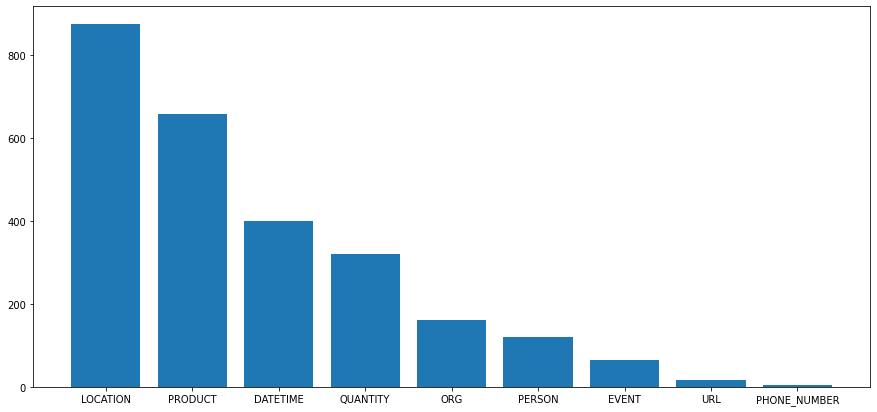

In [18]:
# Horizontal Bar Plot
fig = plt.figure(figsize =(15, 7))
plt.bar(top_entities['Entity Type'], top_entities['Frequency'])
# Show Plot
plt.show()